**Machine Learning Engineer Nanodegree**

**Step 0: Import Data Set**

In this code sectiom, we will import the dataset into our our environment.

* define all external libraries here :



In [1]:
!pip install livelossplot

import os
import tarfile
import zipfile
from six.moves import urllib
import ssl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline 
import xml.etree.ElementTree as ET
import glob
from livelossplot.keras import PlotLossesCallback




print("Libraries are loaded")

Using TensorFlow backend.


Libraries are loaded


* Load the data from the data source

In [0]:
# function extract tar file
def extract_tar(path):
  with tarfile.open(path) as tar_ref:
    tar_ref.extractall()
    tar_ref.close()

In [0]:

# Only required for google colab
 
from google.colab import drive
drive.mount('/content/drive')

In [0]:
cd '/content/drive/My Drive'

In [0]:
# extract the file if not extracted
extract_tar("openlogo.tar")

In [2]:
cd 'openlogo'

/content/openlogo


In [0]:
ls

Annotations/     ImageSets/   resnet50/  vgg19/
cropped_images/  JPEGImages/  standard/




*   Download locally from the internet if dirve is not mounted



In [3]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id = '1p1BWofDJOKXqCtO0JPT5VyuIPOsuxOuj'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('qmul','tar')
#downloaded.GetContentFile('openlogo','tar')

print('File is downloaded')

    100% |████████████████████████████████| 993kB 21.3MB/s 
File is downloaded


In [7]:
ls

Annotations/  ImageSets/  JPEGImages/


In [0]:
# extract the file
extract_tar("qmul")

In [5]:
cd openlogo

/content/openlogo


** Step 1: Explore Data **




*   Let us explore an example of the images from the image folder where all images for the training, validating and testing sets are located. Below are random images selected along with thier annotation .




There are 18752 total raw training logos.
There are 8331 total raw testing logos.


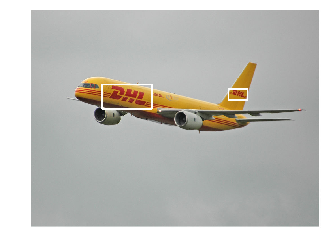

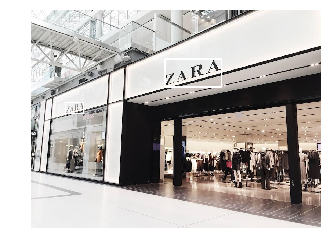

In [3]:
# loading the image data
column_names = ['file_name']
training_validating_data = pd.read_csv('./ImageSets/Main/train_test/train_all.txt', sep=" ", header=None, names = column_names)
testing_data = pd.read_csv('./ImageSets/Main/train_test/test_all.txt', sep=" ", header=None, names = column_names)


print('There are %d total raw training logos.' % len(training_validating_data))
print('There are %d total raw testing logos.' % len(testing_data))


   
    
# function to display an image
def display_image(image_name):
    image_path = './JPEGImages/'+image_name+'.jpg'
    img = cv2.imread(image_path)
    annotate_image(img,image_name)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(cv_rgb)
    plt.show()
    

# function to annotate an image
def annotate_image(img,image_name):
  file_path = './Annotations/'+image_name+'.xml'
  tree = ET.parse(file_path)
  root = tree.getroot()
  folder = root.find("./folder").text
  objects = root.findall("./object/bndbox")
  for object in objects:
    xmin = int(object.find('xmin').text)
    ymin = int(object.find('ymin').text)
    xmax = int(object.find('xmax').text)
    ymax = int(object.find('ymax').text)
    cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,255,255),4)
    

# display image example
display_image('27611353')
display_image('Zaraimg000026')



In [21]:
ls

Annotations/  cropped_images/  ImageSets/  JPEGImages/  resnet50/  standard/




*   Crop images by thier annotations when testing with cropping




In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# crop images by thier annotation 
def crop_images():
    
  #column_names = ['file_name']
  #images = pd.read_csv('./ImageSets/Main/all.txt', sep=" ", header=None, names = column_names)
  
   # total_cropped_images
  print('There are %d total training images.' % len(training_validating_data))
  print('There are %d total testing images.' % len(testing_data))
  all_data= pd.concat([training_validating_data, testing_data])
  print('There are %d total images.' % len(all_data))

     
  if not os.path.isdir('./cropped_images'):
     os.makedirs('./cropped_images')
      
  annotations_files= glob.glob("./Annotations/*.xml")
  count = 0
  
  for image in all_data['file_name'].values:
    #find annotation
    tree = ET.parse("./Annotations/"+image+".xml")
    root = tree.getroot()
    file_name = root.find("./filename").text
    class_name = root.find("./object/name").text
    xmin = int(root.find("./object/bndbox/xmin").text)
    ymin = int(root.find("./object/bndbox/ymin").text)
    xmax = int(root.find("./object/bndbox/xmax").text)
    ymax = int(root.find("./object/bndbox/ymax").text)
    
    img = cv2.imread('./JPEGImages/'+image+'.jpg')   
    crop_img = img[ymin:ymax, xmin:xmax]
#     cv_rgb = cv2.cvtColor(crop_img, cv2.COLOR_BGR2RGB)
#     plt.axis('off')
#     plt.imshow(cv_rgb)
#     plt.show()
    cv2.imwrite(os.path.join('./cropped_images/' , image+'.jpg'), crop_img)
    
  
crop_images()

There are 18752 total training images.
There are 8331 total testing images.
There are 27083 total images.


In [4]:
  total_cropped_images= glob.glob("./cropped_images/*")
  print('There are %d total cropped images.' % len(total_cropped_images))
    


There are 27083 total cropped images.





*   Extract  training and testing  data and classes 



In [0]:
from sklearn.model_selection import train_test_split
# function to create validating_data from training data
def extract_validating_data(training_data,training_classes):
    
    train_data, validating_data, train_target, validating_target = train_test_split(training_data, training_classes, test_size=0.2, random_state=42)
    return (train_data, train_target), (validating_data, validating_target)
  

In [0]:
# function to create array of classes
def extract_data_and_classes():
    # train
    train_data =[]
    train_target = []
    
    # test
    test_data =[]
    test_target = []
    
    # list of annotation files
    annotations_files= glob.glob("./Annotations/*.xml")
  
    # go through annotation files and extract filename and its class
    for annotations_file in annotations_files: 
    
      # parse the xml and extract the file name and class name
      tree = ET.parse(annotations_file)
      root = tree.getroot()
      file_name = root.find("./filename").text
      class_name = root.find("./object/name").text
         
      # set training data
      if file_name[:-4] in training_validating_data['file_name'].values:
        train_data.append(file_name)
        train_target.append(class_name)
     
      # set test data
      if file_name[:-4] in testing_data['file_name'].values:
        test_data.append(file_name)
        test_target.append(class_name)
   

    return (train_data,train_target),(test_data,test_target)
  
   

In [11]:
ls

Annotations/  cropped_images/  ImageSets/  JPEGImages/




*   Load the raw data



In [0]:
# load training and testing data
(training_images,training_classes),(testing_images,testing_classes) = extract_data_and_classes()


In [8]:
# frequency counts
training_classes_value_counts = np.array(np.unique(training_classes, return_counts=True)).T

# training data
small_training_images = []
small_training_classes = []


# print(training_classes_value_counts)


 # Clean the training data
threshold = 10
for class_value_count in training_classes_value_counts:
  if(int(class_value_count[1]) <= threshold):
    for index, training_class in enumerate(training_classes):
      if training_class == class_value_count[0]:
        small_training_images.append(training_images[index])
        small_training_classes.append(training_classes[index])
        
print("Classes with 10 images or below : ", len(small_training_classes))


Classes with 10 images or below :  289


Images per class For Testing Data


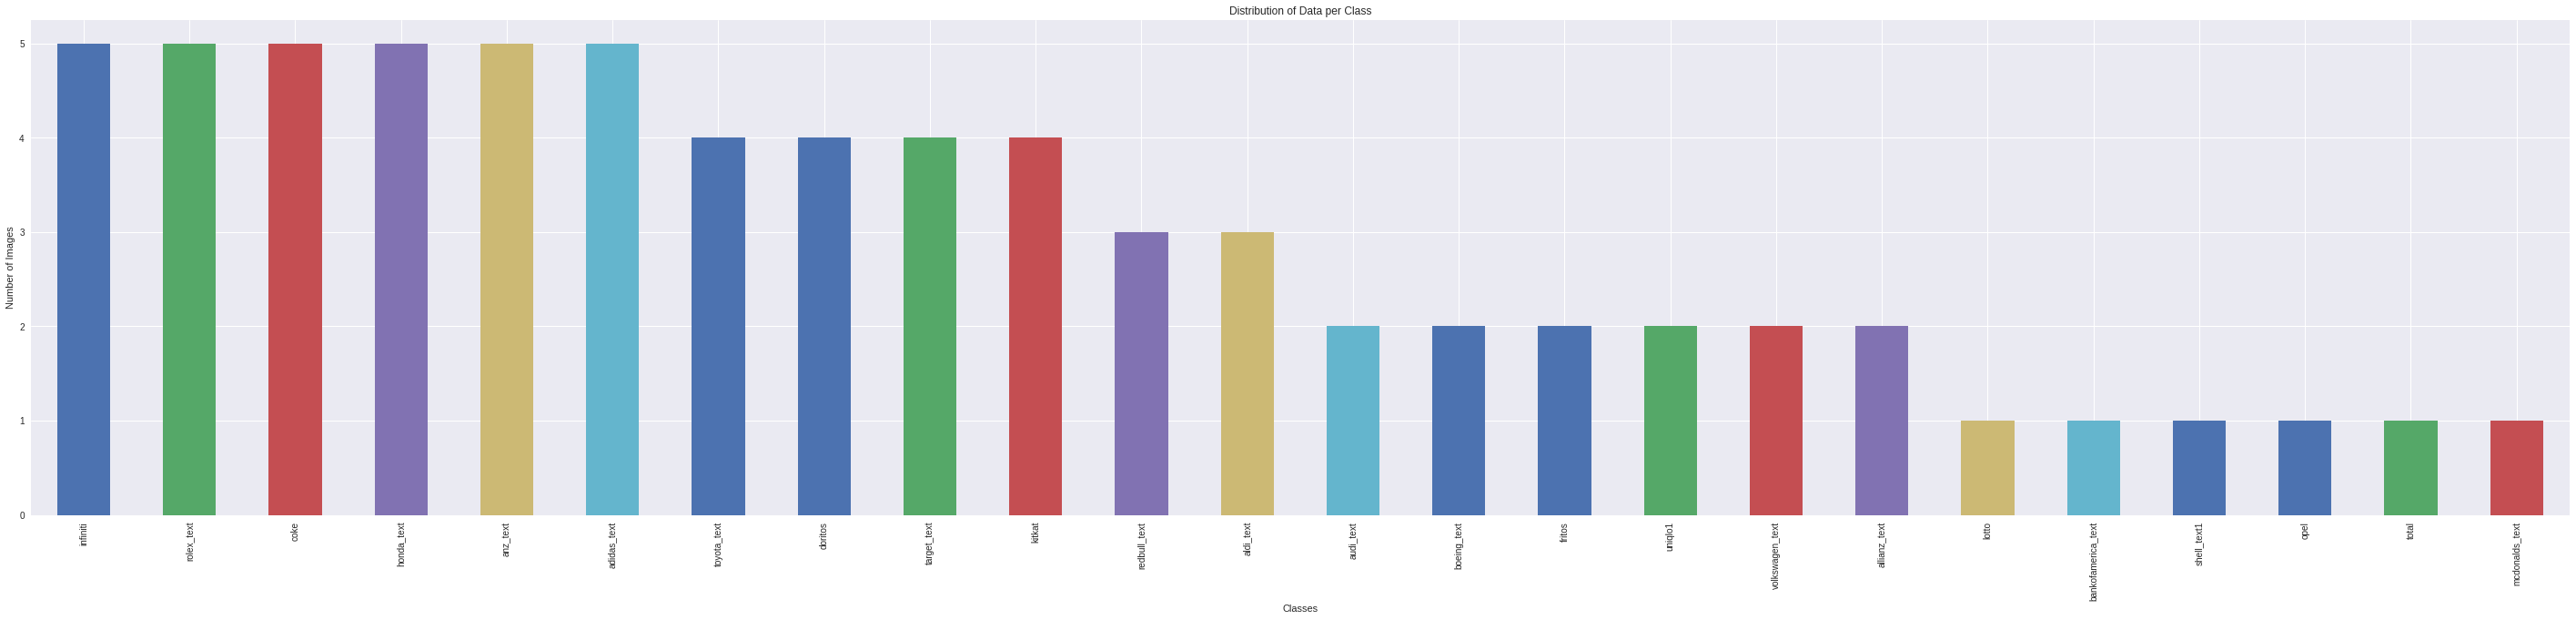

In [0]:
ax =pd.Series(small_training_classes).value_counts().plot(kind='bar',figsize=(50,10), title="Distribution of Data per Class")
ax.set_xlabel("Classes")
ax.set_ylabel("Number of Images")
print("Images per class For Testing Data")



*   Clean the date to only get the data which exsits on Training and Testing Sets with high training date



In [0]:
# frequency counts
training_classes_value_counts = np.array(np.unique(training_classes, return_counts=True)).T

# training data
cleaned_training_images = []
cleaned_training_classes = []



 # Clean the training data
threshold = 250
for class_value_count in training_classes_value_counts:
  if(int(class_value_count[1]) > threshold):
    for index, training_class in enumerate(training_classes):
      if training_class == class_value_count[0]:
        cleaned_training_images.append(training_images[index])
        cleaned_training_classes.append(training_classes[index])




In [0]:

# testing
cleaned_testing_images = []
cleaned_testing_classes = []
test_threshold = 1000
count = 0
for training_class in np.unique(cleaned_training_classes):
  for index, testing_class in enumerate(testing_classes):
    if(testing_class == training_class):
      cleaned_testing_images.append(testing_images[index])
      cleaned_testing_classes.append(testing_classes[index])
      count +=1
      if count > test_threshold:
        break;


In [0]:

backup_training_images = training_images
backup_training_classes = training_classes
backup_testing_images = testing_images
backup_testing_classes = training_classes

training_images = cleaned_training_images
training_classes = cleaned_training_classes
testing_images = cleaned_testing_images
testing_classes = cleaned_testing_classes

In [12]:
print(len(cleaned_training_images), " VS  ", len(training_images))
print(len(cleaned_testing_images), " VS ", len(testing_images))



5554  VS   5554
1010  VS  1010


Images per class for Training Data


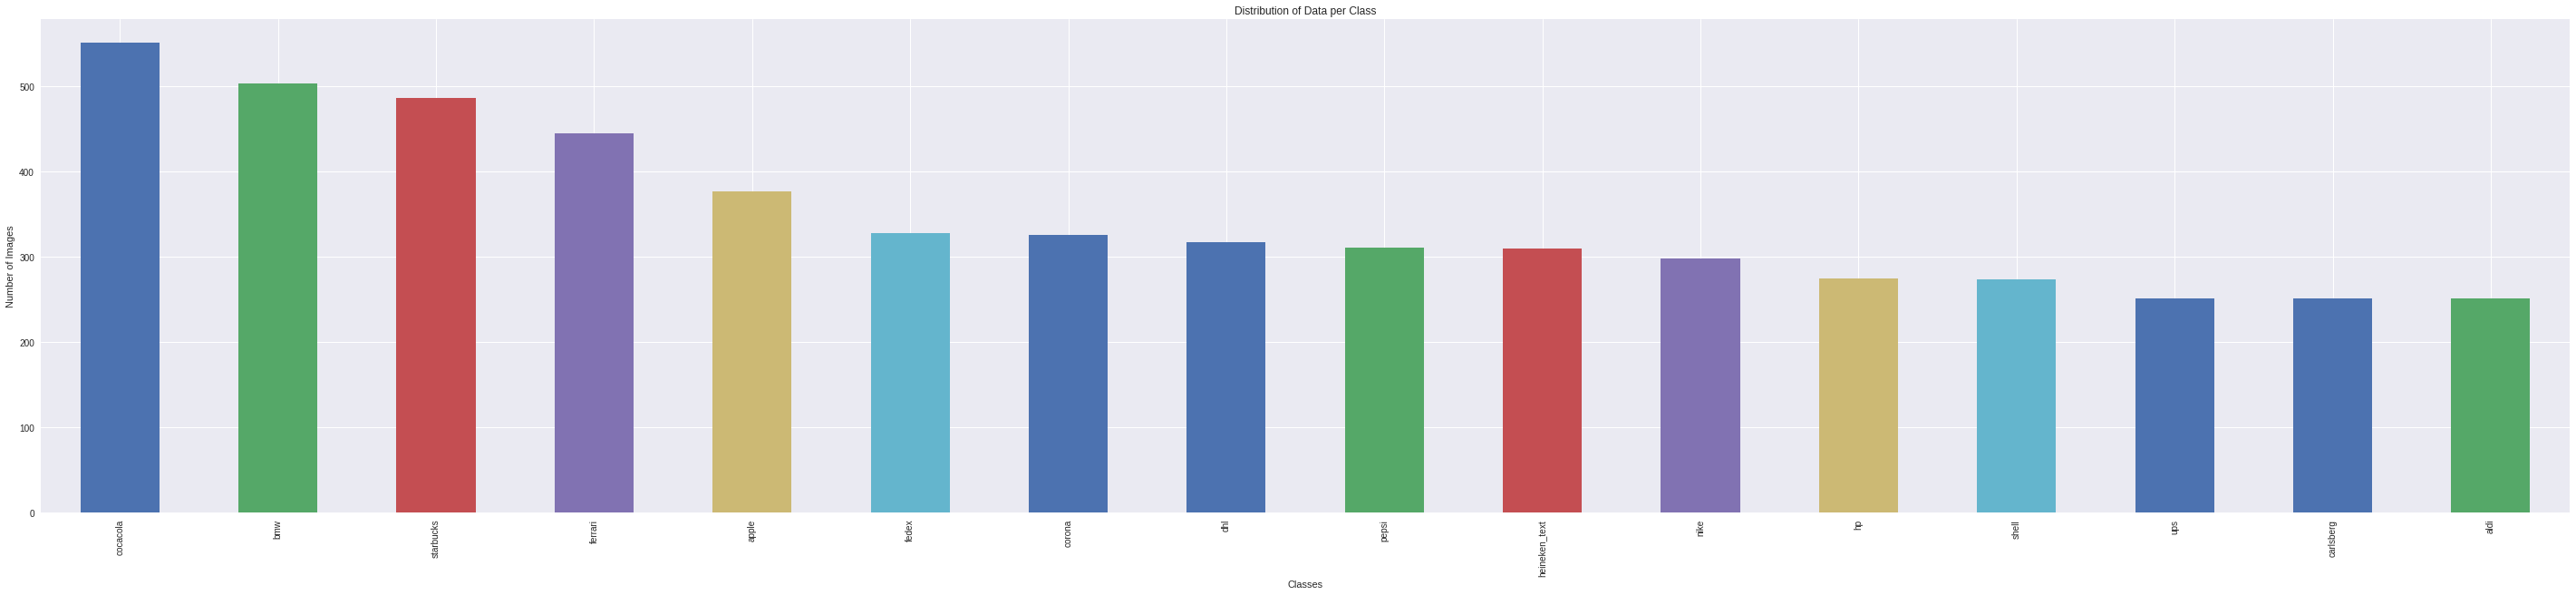

In [0]:
ax =pd.Series(training_classes).value_counts().plot(kind='bar',figsize=(50,10), title="Distribution of Data per Class")
ax.set_xlabel("Classes")
ax.set_ylabel("Number of Images")
print("Images per class for Training Data")

Images per class For Testing Data


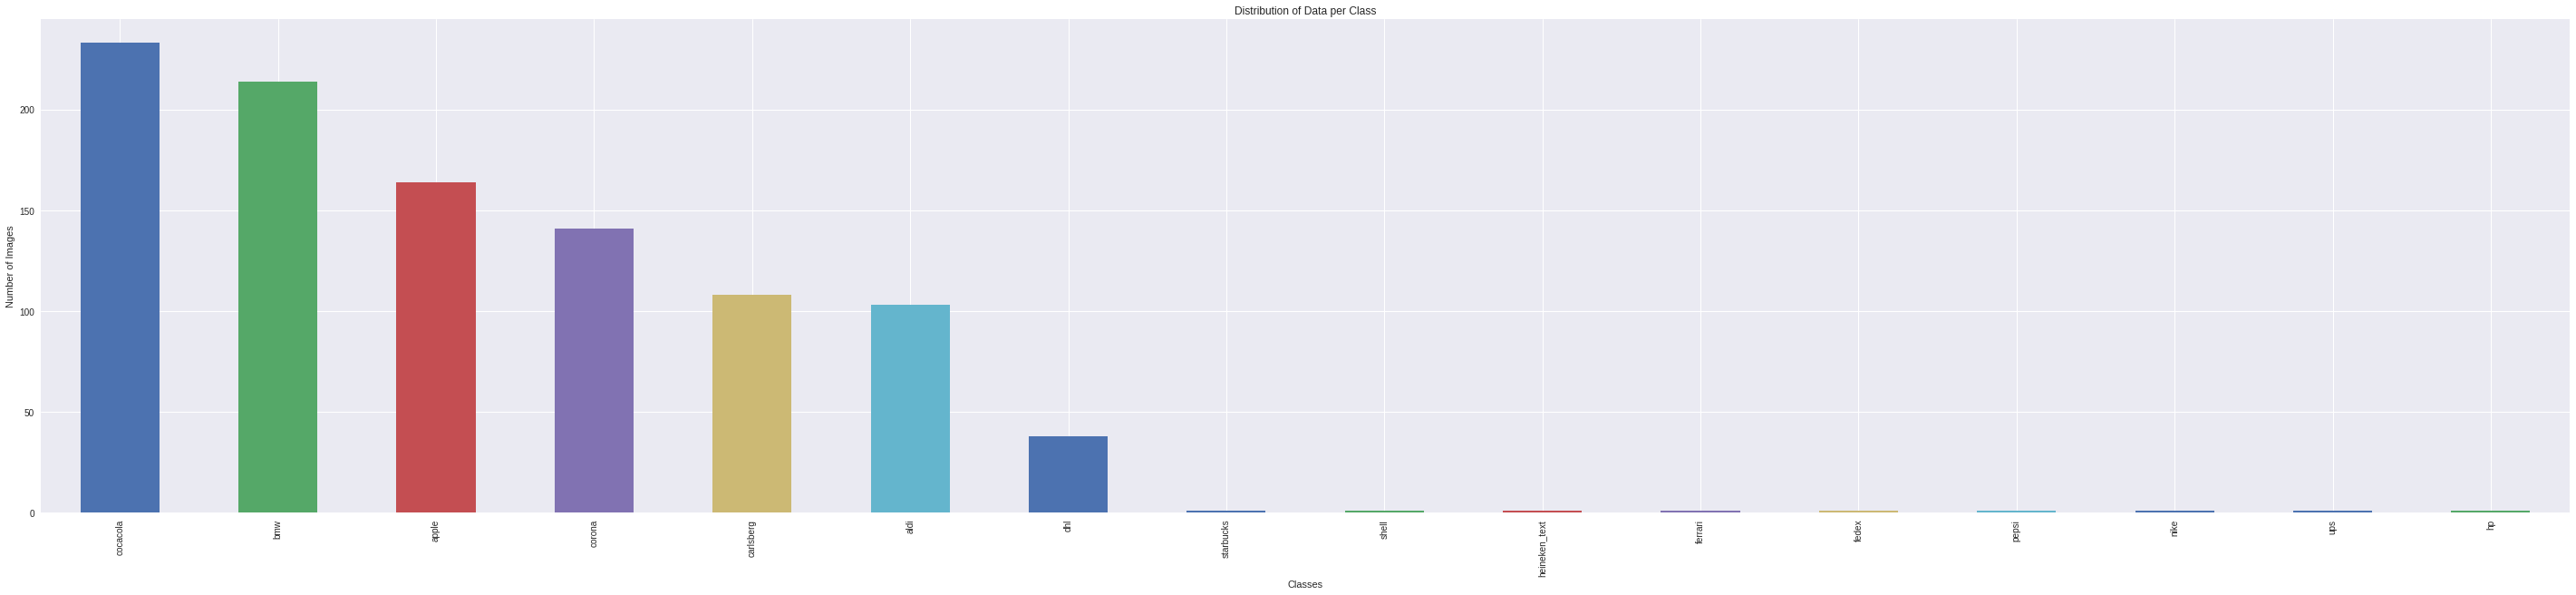

In [0]:
ax =pd.Series(testing_classes).value_counts().plot(kind='bar',figsize=(50,10), title="Distribution of Data per Class")
ax.set_xlabel("Classes")
ax.set_ylabel("Number of Images")
print("Images per class For Testing Data")



*   Summary of the Data



Total Training images :  4443
Total Validating images :  1111
Total Testting images :  1010
Total Classes :  16
file name:  logos32plus_003947.jpg  class :  ferrari


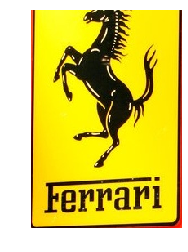

file name:  McDonaldsimg000403.jpg  class :  cocacola


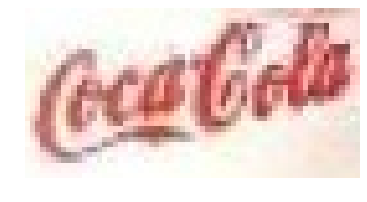

file name:  2874380405.jpg  class :  ups


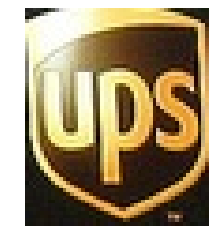

file name:  logos32plus_001968.jpg  class :  cocacola


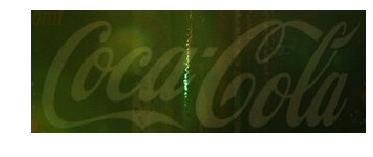

In [13]:

# find the total classes
original_classes = np.unique(training_classes)

# create validating data from the training data
(training_images,training_classes),(validating_images,validating_classes)= extract_validating_data(training_images,training_classes)

print("Total Training images : ", len(training_images))
print("Total Validating images : ", len(validating_images))
print("Total Testting images : ", len(testing_images))
print("Total Classes : ", len(original_classes))


# display the image
def display_image(image_name):
    #image_path = './JPEGImages/'+image_name
    image_path = './cropped_images/'+image_name
    img = cv2.imread(image_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(cv_rgb)
    plt.show()
    
from random import randint
# display random images
count =0
while count < 4 :
  index =  randint(0, len(training_images)-1)
  count +=1
  print("file name: ", training_images[index], " class : ", training_classes[index])
  try :
    display_image(training_images[index])
  except:
     print("image does not exsit!")

**Step 2 : Pre-processing model **



*   hot encoded classes



In [14]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


decoded_training_classes = training_classes 
decoded_validating_classes =validating_classes 
decoded_testing_classes =testing_classes 


#create lables 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(decoded_training_classes)
# one hot encode
encoded_training_classes = to_categorical(integer_encoded,len(original_classes))

#create lables 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(decoded_validating_classes)
# one hot encode
encoded_validating_classes = to_categorical(integer_encoded,len(original_classes))


#create lables 
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(decoded_testing_classes)
print(integer_encoded)
# one hot encode

encoded_testing_classes = to_categorical(integer_encoded,len(original_classes))


# print(testing_classes[4])
# print(encoded_testing_classes[4])
# print(np.argmax(encoded_testing_classes[4]))


#invert encoding
# inverted = label_encoder.inverse_transform([np.argmax(encoded_testing_classes[0])])

# inverted = label_encoder.inverse_transform([np.argmax(integer_encoded[23])])
# print(inverted)


[ 0  0  0 ... 13 14 15]




*   convert data to tensors




In [0]:
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  


# codes to convert image to tesnor
def path_to_tensor(img_path):
  
     
  try:
    # loads RGB image as PIL.Image.Image type
    #img = image.load_img("./JPEGImages/"+img_path, target_size=(228, 228))
    #img = image.load_img("./cropped_images/"+img_path, target_size=(228, 228))
    img = image.load_img(image_folder+img_path, target_size=(228, 228))

    
    # convert PIL.Image.Image type to 3D tensor with shape (228, 228, 3)
    x = image.img_to_array(img)
    
    # rescale image
    x = x.astype('float32')
    
    # convert 3D tensor to 4D tensor with shape (1, 228, 228, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)
  except:
    print (img_path, " not found !")
    



def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

  
# extract based on our the logo dataset 
def extract_features_for_logos(pre_trained_model,data, file_prefix, save=True):
    
    # extract data features for given dataset
    data_features = pre_trained_model.predict(preprocess_input(paths_to_tensor(data)))
    if save:
        np.save(file_prefix + '_features', data_features)
    return data_features

**Step 3: Create a standard CNN Model**

In [16]:
image_folder ="./cropped_images/"
train_tensors = paths_to_tensor(training_images).astype('float32')/255
valid_tensors = paths_to_tensor(validating_images).astype('float32')/255
test_tensors = paths_to_tensor(testing_images).astype('float32')/255

100%|██████████| 1010/1010 [00:01<00:00, 514.42it/s]




*   Setup the Network Model




In [28]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential

# Define your architecture.
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=2, padding='same', activation='relu', input_shape=(228,228,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(.3))
model.add(Conv2D(filters=128,kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(.5))
model.add(Conv2D(filters=64,kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(original_classes),activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 228, 228, 32)      416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 114, 114, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 114, 114, 128)     16512     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 57, 57, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)  



*   Compile the Model




In [0]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['categorical_accuracy'])



*   Train the Model



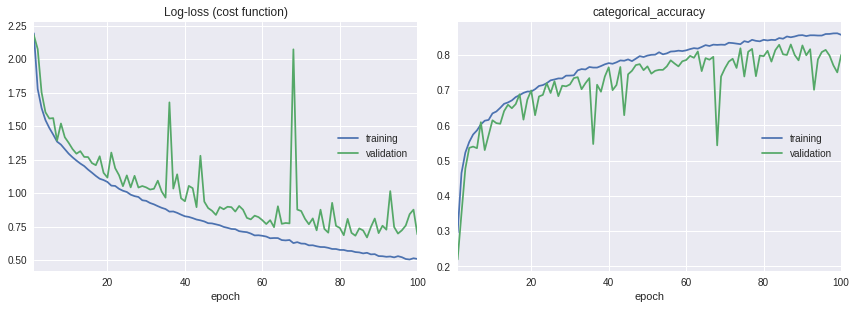

Log-loss (cost function):
training   (min:    0.506, max:    2.193, cur:    0.510)
validation (min:    0.670, max:    2.180, cur:    0.694)

categorical_accuracy:
training   (min:    0.297, max:    0.862, cur:    0.857)
validation (min:    0.220, max:    0.830, cur:    0.800)


In [30]:
if not os.path.isdir('./standard'):
  os.makedirs('./standard')

checkpointer = ModelCheckpoint(filepath='standard/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)


model.fit(train_tensors,encoded_training_classes,
                 validation_data=(valid_tensors,encoded_validating_classes),
                 epochs=100,
                 batch_size=20,
                 callbacks=[checkpointer,PlotLossesCallback()],
                 verbose=1)




*   Load the Model weights



In [0]:
model.load_weights('standard/weights.best.from_scratch.hdf5')



*   Test the Model 



In [32]:
model_predictions = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in test_tensors]

test_accuracy = 100*np.sum(np.array(model_predictions)== [np.argmax(test_class) for test_class in encoded_testing_classes])/len(model_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 80.4950%


**Step 4: Create a CNN Model using Restnet 50**

*   Extract Restnet 50 features and save them


In [35]:
from keras.applications.resnet50 import ResNet50, preprocess_input
image_folder ="./cropped_images/"

  
pre_trained_model = ResNet50(weights='imagenet', include_top=False)

if not os.path.isdir('./resnet50'):
  os.makedirs('./resnet50')
  
#if not os.path.isfile('./resnet50/train_features.npy'):
  # extract features and then store them
extract_features_for_logos(pre_trained_model,training_images, './resnet50/train')
extract_features_for_logos(pre_trained_model,validating_images, './resnet50/validate')
extract_features_for_logos(pre_trained_model,testing_images, './resnet50/test')

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
100%|██████████| 1010/1010 [00:04<00:00, 239.91it/s]


array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.6414688 , 0.        ],
         [0.        , 3.6594262 , 0.        , ..., 0.        ,
          0.04706246, 0.        ],
         [0.        , 3.5280638 , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.05310535, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          7.468293  , 0. 



*   Loading features of RestNet 50


In [0]:


train_RESNET50 = np.load('./resnet50/train_features.npy')
valid_RESNET50 = np.load('./resnet50/validate_features.npy')
test_RESNET50 =  np.load('./resnet50/test_features.npy')





*   Setup the Model



In [37]:
RESNET50_model = Sequential()
RESNET50_model.add(GlobalAveragePooling2D(input_shape=train_RESNET50.shape[1:]))
RESNET50_model.add(Dense(128, activation='relu'))
RESNET50_model.add(Dropout(.5))
RESNET50_model.add(Dense(1025, activation='relu'))
RESNET50_model.add(Dropout(.5))
RESNET50_model.add(Dense(512, activation='relu'))
RESNET50_model.add(Dense(len(original_classes), activation='softmax'))
RESNET50_model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1025)              132225    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1025)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               525312    
___________________________



*   compile the model




In [0]:
from keras import metrics
RESNET50_model.compile(loss='categorical_crossentropy',optimizer="rmsprop",  metrics=['categorical_accuracy'])



* Train the model 




In [39]:
encoded_validating_classes.shape

(1111, 16)

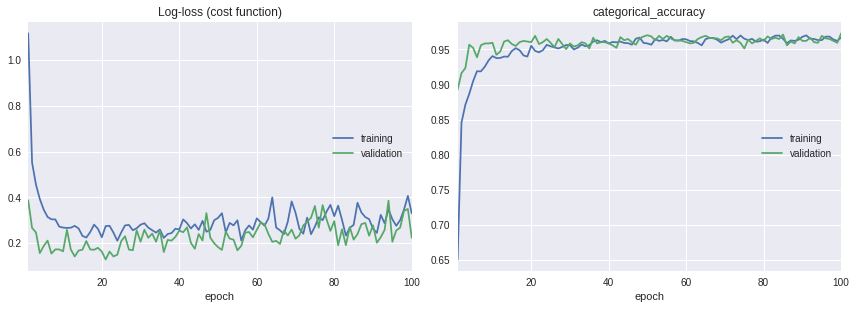

Log-loss (cost function):
training   (min:    0.210, max:    1.117, cur:    0.330)
validation (min:    0.128, max:    0.387, cur:    0.223)

categorical_accuracy:
training   (min:    0.651, max:    0.970, cur:    0.967)
validation (min:    0.893, max:    0.973, cur:    0.973)


In [40]:
checkpointer = ModelCheckpoint(filepath='./resnet50/weights.best.ResNet50.hdf5', verbose=1, save_best_only=True)

RESNET50_model.fit(train_RESNET50,encoded_training_classes,
                 validation_data=(valid_RESNET50,encoded_validating_classes),
                 epochs=100,
                 batch_size=20,
                 callbacks=[checkpointer,PlotLossesCallback()],
                 verbose=1)



*   load the model


In [0]:
RESNET50_model.load_weights('./resnet50/weights.best.ResNet50.hdf5')




*   Test the Model





In [42]:
RESNET50_model_predictions = [np.argmax(RESNET50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_RESNET50]


# report test accuracy
test_accuracy = 100*np.sum(np.array(RESNET50_model_predictions)== [np.argmax(test_class) for test_class in encoded_testing_classes])/len(RESNET50_model_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)


Test accuracy: 95.8416%


**Step 5: Create a CNN Model using VGG-19 **


*    Extract VGG 19 features and save them





In [23]:
from keras.applications.vgg19 import VGG19, preprocess_input

  
pre_trained_model = VGG19(weights='imagenet', include_top=False)

if not os.path.isdir('./vgg19'):
  os.makedirs('./vgg19')
  
extract_features_for_logos(pre_trained_model,training_images, './vgg19/train')
extract_features_for_logos(pre_trained_model,validating_images, './vgg19/validate')
extract_features_for_logos(pre_trained_model,testing_images, './vgg19/test')

100%|██████████| 1010/1010 [00:02<00:00, 449.95it/s]


array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 3.5393293e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 1.7758203e+00, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, .



*   Load features of VGG19




In [0]:

train_VGG19 = np.load('./vgg19/train_features.npy')
valid_VGG19 = np.load('./vgg19/validate_features.npy')
test_VGG19 =  np.load('./vgg19/test_features.npy')

(4443, 7, 7, 512)


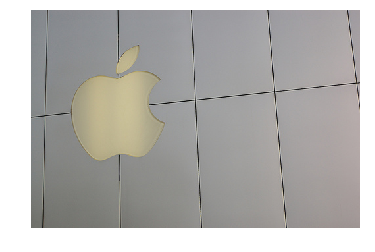

In [25]:
print(train_VGG19.shape)
image_path='./JPEGImages/flickrlogo27_354643240.jpg'
img = cv2.imread(image_path)
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(cv_rgb)
plt.show()



*   Setup the Model



In [27]:
VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
VGG19_model.add(Dense(128, activation='relu'))
VGG19_model.add(Dropout(.5))
VGG19_model.add(Dense(1025, activation='relu'))
VGG19_model.add(Dropout(.5))
VGG19_model.add(Dense(512, activation='relu'))
VGG19_model.add(Dense(len(original_classes), activation='softmax'))
VGG19_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_12  (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 1025)              132225    
_________________________________________________________________
dropout_24 (Dropout)         (None, 1025)              0         
_________________________________________________________________
dense_47 (Dense)             (None, 512)               525312    
_________________________________________________________________
dense_48 (Dense)             (None, 16)                8208      
Total para



*   Compile the Model




In [0]:
from keras import metrics
VGG19_model.compile(loss='categorical_crossentropy',optimizer="rmsprop",  metrics=['categorical_accuracy'])



*   Train The Model



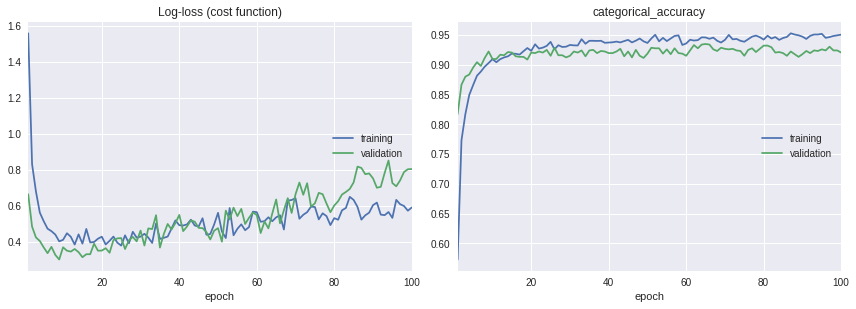

Log-loss (cost function):
training   (min:    0.379, max:    1.557, cur:    0.590)
validation (min:    0.301, max:    0.851, cur:    0.803)

categorical_accuracy:
training   (min:    0.573, max:    0.953, cur:    0.951)
validation (min:    0.817, max:    0.935, cur:    0.921)


In [29]:
checkpointer = ModelCheckpoint(filepath='./vgg19/weights.best.vgg19.hdf5', verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19,encoded_training_classes,
                 validation_data=(valid_VGG19,encoded_validating_classes),
                 epochs=100,
                 batch_size=20,
                 callbacks=[checkpointer,PlotLossesCallback()],
                 verbose=1)



*   Load the Model weights




In [0]:
VGG19_model.load_weights('./vgg19/weights.best.vgg19.hdf5')

In [31]:
VGG19_model_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]


# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_model_predictions)== [np.argmax(test_class) for test_class in encoded_testing_classes])/len(VGG19_model_predictions) 
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 90.7921%


**K-FOLD Cross Validation**

In [0]:
# extract based on our the logo dataset 
def extract_features_from_ready_model(pre_trained_model,data, file_prefix, save=True):
    
    # extract data features for given dataset
    data_features = pre_trained_model.predict(preprocess_input(paths_to_tensor(data)))
    if save:
        np.save(file_prefix + '_features', data_features)
    return data_features

In [18]:
from keras.applications.vgg19 import VGG19, preprocess_input

pre_trained_model = VGG19(weights='imagenet', include_top=False)

if not os.path.isdir('./vgg19_cv'):
  os.makedirs('./vgg19_cv')

Instructions for updating:
Colocations handled automatically by placer.


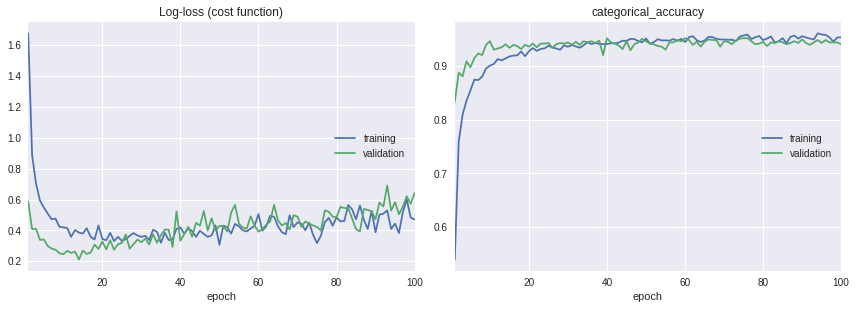

Log-loss (cost function):
training   (min:    0.306, max:    1.677, cur:    0.471)
validation (min:    0.212, max:    0.691, cur:    0.641)

categorical_accuracy:
training   (min:    0.539, max:    0.962, cur:    0.954)
validation (min:    0.834, max:    0.952, cur:    0.941)
Test accuracy: 90.0990%


In [21]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=48)
cvscores = []
count = 0;


for train_indices, valid_indices in kfold.split(training_images, training_classes):
  
  np_training_images = np.array(training_images)
  np_training_classes = np.array(training_classes)
  

  train_images = np_training_images[train_indices]
  train_classes = np_training_classes[train_indices]

  #encode train
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(train_classes)
  encoded_train_classes = to_categorical(integer_encoded,len(original_classes))

  
  valid_images = np_training_images[valid_indices]
  valid_classes = np_training_classes[valid_indices]
  
  #encode valid
  label_encoder = LabelEncoder()
  integer_encoded = label_encoder.fit_transform(valid_classes)
  encoded_valid_classes = to_categorical(integer_encoded,len(original_classes))

  
  count += 1
  
  #extract feature
  extract_features_from_ready_model(pre_trained_model,train_images,'./vgg19_cv/train')
  extract_features_from_ready_model(pre_trained_model,valid_images,'./vgg19_cv/validate')
  extract_features_from_ready_model(pre_trained_model,testing_images,'./vgg19_cv/test')

  # load weights
  train_VGG19 = np.load('./vgg19_cv/train_features.npy')
  valid_VGG19 = np.load('./vgg19_cv/validate_features.npy')
  test_VGG19 = np.load('./vgg19_cv/test_features.npy')

  # setup model
  VGG19_model = Sequential()
  VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
  VGG19_model.add(Dense(128, activation='relu'))
  VGG19_model.add(Dropout(.5))
  VGG19_model.add(Dense(1025, activation='relu'))
  VGG19_model.add(Dropout(.5))
  VGG19_model.add(Dense(512, activation='relu'))
  VGG19_model.add(Dense(len(original_classes), activation='softmax'))
  VGG19_model.summary()
  
  # comiple model
  VGG19_model.compile(loss='categorical_crossentropy',optimizer="rmsprop",  metrics=['categorical_accuracy'])
  
  #run the model
  checkpointer = ModelCheckpoint(filepath='./vgg19_cv/weights.best.vgg19.hdf5', verbose=1, save_best_only=True)
  VGG19_model.fit(train_VGG19,encoded_train_classes,
                 validation_data=(valid_VGG19,encoded_valid_classes),
                 epochs=100,
                 batch_size=20,
                 callbacks=[checkpointer,PlotLossesCallback()],
                 verbose=1)
  
  # Load the best weight
  VGG19_model.load_weights('./vgg19_cv/weights.best.vgg19.hdf5')
  
  
  #load 
  VGG19_model_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]
  # report test accuracy
  test_accuracy = 100*np.sum(np.array(VGG19_model_predictions)== [np.argmax(test_class) for test_class in encoded_testing_classes])/len(VGG19_model_predictions) 
  print('Test accuracy: %.4f%%' % test_accuracy)
  cvscores.append(test_accuracy)







In [22]:
print("accuracy over the validation folds")
for score in cvscores:
    print('%.2f%%' % score)

accuracy over the validation folds
92.28%
91.88%
91.78%
90.79%
90.10%


**Utilties**



*   Image augmentation per class




In [0]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

def augment_dataset(images,classes):
  
  datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
  
  
  if not os.path.isdir('./augment'):
     os.makedirs('./augment')
  
  # create folders of class
  for logo_class in classes:
    if not os.path.isdir('./augment/'+logo_class):
      os.makedirs('./augment/'+logo_class)
  
  #augment the images
  index = 0
  total = len(classes)
  for image in images:
    img = load_img('./JPEGImages/'+image)  # this is a PIL image
    x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    
    if not os.path.isdir('./augment/'+classes[index]):
      print("category not found", classes[index] )
      continue;
      
    total-=1
    print("saved :", classes[index], "left:", total)
    i = 0
    for batch in datagen.flow(x, batch_size=1, save_to_dir='./augment/' +classes[index], save_prefix='augment', save_format='jpeg'):
      i += 1
      if i > 10:
        break  # otherwise the generator would loop indefinitely 
    index +=1
    

augment_dataset(training_images,training_classes)

In [0]:
ls

In [0]:
# from sklearn.datasets import load_files       
# from keras.utils import np_utils

# # define function to load train, test, and validation datasets
# def load_dataset(path):
#     data = load_files(path)
#     return data
#     #dog_files = np.array(data['filenames'])
#     #dog_targets = np_utils.to_categorical(np.array(data['target']), 16)
#     #return dog_files
#   #, dog_targets
  
  
# train_files, train_targets = load_dataset('./augment')


In [0]:
rm -rf "openlogo"

In [0]:
ls